In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from src.config import *
from src.prediction_functions import *
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from src.prediction_functions.MatrixMultiplicationMemoryEffectiveChunks import estimate_receptor_activity


# Read in data

In [50]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [51]:
confidence_metric = 'mwu_pvalue'# 'ROCAUC'

In [52]:
lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col =0)
lincs_model = lincs_model.T

In [53]:
lincs_model.shape

(978, 229)

In [54]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]
lr_associations_receptor = lr_associations[lr_associations['target_genesymbol'].isin(lincs_model.columns)]

In [55]:
cytosig_data = pd.read_csv(f'data/cytosig/diff.merge.gz', compression='gzip', sep = '\t')
cytosig_data = cytosig_data.T

In [56]:
cytosig_data = cytosig_data[set(lincs_model.index) & set(cytosig_data.columns)]

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_46684/3224514197.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cytosig_data = cytosig_data[set(lincs_model.index) & set(cytosig_data.columns)]


In [57]:
additional_mapping = {
       'IFNA':'IFNA1', 
       'IFNB':'IFNB1',
       'IFNL':'IFNL1', 
       'TNFA':'TNF', 
       'IL12':'IL12B', 
       'CD40L':'CD40LG', 
       'GMCSF':'CSF2', 
       'MCSF':'CSF1',
       'IL1':'IL1A', 
       'TWEAK':'TNFRSF12A',
       'TRAIL':'TNFSF10',
       'GCSF':'CSF3',
       'IL32':'IL32',
       'OPGL':'TNFSF11',
       'BAFF':'TNFSF13B',
       '41BBL':'TNFSF9',
       'IL23':'IL23A', 
       'CXCL4':'PF4',
       'Activin A':'INHBA',
       'ANGPTL4':'ANGPTL4',
       'ANGPTL2':'ANGPTL2',
       'PGE2':'PTGES2',
       'NO':'NO',
       'PDL1':'CD274'
}
inverse_additional_mapping = {v: k for k, v in additional_mapping.items()}

In [58]:
a_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'A']['Receptor'])
b_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'B']['Receptor'])
c_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'C']['Receptor'])
d_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'D']['Receptor'])
e_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'E']['Receptor'])

In [59]:
lincs = {}

In [60]:
# get the gene symbol of cytosig cytokines
cytosig_cytokines = pd.DataFrame(index = cytosig_data.index, columns = ['cytokines'])
cytosig_cytokines['cytokines'] = cytosig_data.index.str.split('@', expand = True).get_level_values(0).str.split('&', expand = True).get_level_values(0)
cytosig_cytokines['cytokine_genesymbol'] = cytosig_cytokines['cytokines'].map(additional_mapping).fillna(cytosig_cytokines['cytokines'])

In [61]:
number_of_signatures_receptor_cytosig = {}
i = 0
receptors = lincs_model.columns
for rec in receptors:
    ligandsofrec = lr_associations[lr_associations['target_genesymbol'] == rec]
    for lig in ligandsofrec.source_genesymbol:
        cytosig_cytokines_lig = cytosig_cytokines[cytosig_cytokines['cytokine_genesymbol'] ==lig]
        cytosig_cytokines_lig = {'receptor':rec, 'ligand':lig, 'number_of_sigs':len(cytosig_cytokines_lig)}
        number_of_signatures_receptor_cytosig[i] = cytosig_cytokines_lig
        i = i+1
number_of_signatures_receptor_cytosig = pd.DataFrame(number_of_signatures_receptor_cytosig).T
number_of_signatures_receptor_cytosig_sum = number_of_signatures_receptor_cytosig.groupby('receptor')[['number_of_sigs']].sum()

In [62]:
full_cytokine_mapping = cytosig_cytokines.drop_duplicates().set_index('cytokines')['cytokine_genesymbol'].to_dict()
inverse_full_cytokine_mapping = {v: k for k, v in full_cytokine_mapping.items()}

# Prediction

In [63]:
cytosig_data.isna().any().any()

True

In [64]:
lincs['all'] = estimate_receptor_activity(cytosig_data, lincs_model, number_of_permutations=100, chunk_size=300)

Number of samples: 2056
Number of chunks: 7
Number of permutations: 100


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


In [65]:
# lincs['all'].to_csv('results/temp/lincs_cytosig_prediction_filteredsignatures.csv')

In [66]:
lincs['A']  = lincs['all'].loc[:, a_scored_receptors]
lincs['B']  = lincs['all'].loc[:, b_scored_receptors]
lincs['C']  = lincs['all'].loc[:, c_scored_receptors]
lincs['D']  = lincs['all'].loc[:, d_scored_receptors]
lincs['E']  = lincs['all'].loc[:, e_scored_receptors]

In [67]:
lincs['A'].shape, lincs['B'].shape, lincs['C'].shape, lincs['D'].shape, lincs['E'].shape

((2056, 42), (2056, 42), (2056, 42), (2056, 42), (2056, 61))

In [68]:
def calulate_ridden_rocauc(receptor_activity, lr_associations_receptor = lr_associations_receptor):
    true_matrix = pd.DataFrame(0, index = receptor_activity.index, columns = receptor_activity.columns)
    pair_set = set(zip(lr_associations_receptor['source_genesymbol'], lr_associations_receptor['target_genesymbol']))
    for sample in true_matrix.index:
        sample_cytokine = sample.split('@')[0].split('&')[0]
        if sample_cytokine in inverse_full_cytokine_mapping.keys():
            ligand = inverse_full_cytokine_mapping[sample_cytokine]
        else:
            continue
        for receptor in true_matrix.columns:
            if (ligand, receptor) in pair_set:
                true_matrix.at[sample, receptor] = 1
    # true_matrix = true_matrix[true_matrix.sum(1) != 0]
    true_matrix = true_matrix[true_matrix.columns[true_matrix.sum() !=0]]
    samples = true_matrix.index
    receptors = true_matrix.columns
    receptor_activity_fil = receptor_activity.loc[samples, receptors]
    roc_auc_dict = {}
    for receptor in receptor_activity_fil.columns:
        true_vector = true_matrix.loc[:, receptor]
        values = receptor_activity_fil.loc[:, receptor]
        roc_auc_binary = roc_auc_score(true_vector, values)
        roc_auc_dict[receptor] = roc_auc_binary
    roc_auc_results_lincs = pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC'])
    return roc_auc_results_lincs

In [69]:
rocauc_results = {}
true_matrices = {}
for conflevel in ['A', 'B', 'C', 'D', 'E', 'all']:
    rocauc_results[conflevel] = calulate_ridden_rocauc(lincs[conflevel])

In [70]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x-0.2, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [71]:
rocauc_results_all = pd.concat(rocauc_results).reset_index(level=0).rename(columns={'level_0': 'ConfidenceLevel'})


In [72]:
rocauc_results_all['ConfidenceLevel'] = rocauc_results_all['ConfidenceLevel'].map({'A':'RIDDEN A', 'B':'RIDDEN B', 'C':'RIDDEN C', 'D':'RIDDEN D','E':'RIDDEN E', 'all':'RIDDEN ALL'})

In [73]:
# rocauc_results_all.to_csv('results/benchmark/cytosig_lincs_rocauc_confidence.csv')

### CytoSig predict RIDDEN

In [74]:
# !python CytoSig_run.py -i data/lincs_consensus/high_quality/inf_pert_cell_liana_transp.csv -o ./results/benchmark/cytosig_prediction_inferred_signature2.Coef

In [75]:
cytokine_signalling_activity = pd.read_csv('results/benchmark/cytosig_prediction_inferred_signature2.Coef.Coef', index_col = 0, sep = '\t' )
cytokine_signalling_activity = cytokine_signalling_activity.T

In [76]:
lincs_metadata = pd.read_csv('results/benchmark/lincs_translate_to_ligands.csv', index_col = 0)

In [77]:
cytokine_signalling_activity = cytokine_signalling_activity.loc[lincs_metadata.index]

In [78]:
mapped_columns = cytokine_signalling_activity.columns.map(lambda x: additional_mapping.get(x, x))
cytokine_signalling_activity.columns = mapped_columns

In [79]:
signed_interactions = lincs_metadata['signed_interactions_lig'].apply(eval).apply(pd.Series)

metadata = pd.DataFrame(index=lincs_metadata.index)
metadata = metadata.merge(signed_interactions, left_index=True, right_index=True, how='left').fillna(0)

In [80]:
common_cytokines = sorted(list(set(cytokine_signalling_activity) & set(metadata.columns)))

In [81]:
metadata = metadata[common_cytokines]
metadata = metadata[metadata.abs().sum(1)!=0]
cytokine_signalling_activity = cytokine_signalling_activity.loc[metadata.index, common_cytokines]

### Negative and positive binary

In [82]:
def create_negativ_and_positive_binary(metadata):
    binary = metadata.copy()
    if (binary == -1).any().any() == False:
        print('There are only positive perturbations, no negative matrix')
        negative_binary = pd.DataFrame()
    else:
        negative_binary = binary.replace({1:0})
        assert set(np.unique(negative_binary.values)) == {-1, 0}
        # delete only 0 rows
        s = negative_binary.sum() != 0
        negative_binary = negative_binary.loc[:, s.values]
        # change sign
        negative_binary = negative_binary.replace({-1:1})
        assert set(np.unique(negative_binary.values)) == {0, 1}

    if (binary == 1).any().any() == False:
        print('There are only negative perturbations, no positive matrix')
        positive_binary = pd.DataFrame()
    else: 
        positive_binary = binary.replace({-1:0})
        assert set(np.unique(positive_binary.values)) == {0, 1}
        # delete only 0 rows
        s = positive_binary.sum() != 0
        positive_binary = positive_binary.loc[:, s.values]

    return negative_binary, positive_binary

In [83]:
def calculate_rocaucs(binary, activities):
    receptors = list(set(activities.columns) & set(binary.columns))
    filtered_activities  = activities.loc[binary.index, receptors]
    filtered_binary = binary.loc[filtered_activities.index,receptors]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for receptor in filtered_binary.columns:
        roc_auc[receptor] = roc_auc_score(filtered_binary.loc[:, receptor], filtered_activities.loc[:, receptor])
    return roc_auc


In [84]:
negative, positive = create_negativ_and_positive_binary(metadata)

In [85]:
rocauc_negative = calculate_rocaucs(negative, cytokine_signalling_activity)
rocauc_positive = calculate_rocaucs(positive, cytokine_signalling_activity)

In [86]:
rocauc_cytosig = pd.concat([1-pd.Series(rocauc_negative), pd.Series(rocauc_positive)], axis = 1).max(1)

In [87]:
rocauc_cytosig = pd.DataFrame(rocauc_cytosig)
rocauc_cytosig['ConfidenceLevel'] = 'CytoSig'

In [88]:
rocauc_cytosig = rocauc_cytosig.rename(columns = {0:'ROC AUC'})

In [89]:
rocauc_results_all2 = pd.concat([rocauc_results_all, rocauc_cytosig])

In [249]:
# rocauc_results_all2.to_csv('results/benchmark/cytosig_lincs_rocauc_confidence_max.csv')

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_46684/3679344899.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all2, palette = 'Paired')


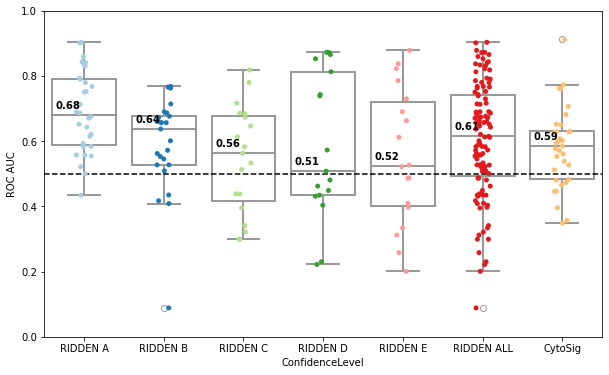

In [92]:
# Plot the boxplot
plt.figure(figsize=(10, 6))
boxp = sns.boxplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all2, color = 'white', linewidth=2)
sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all2, palette = 'Paired')
add_median_labels(boxp)
plt.ylabel('ROC AUC')
plt.ylim(0, 1)
plt.axhline(0.5, color = 'k', linestyle = '--')
plt.show()